In [ ]:
# import os

# # Define the directory path
# directory = '/kaggle/input/gans-dataset-cp'

# # Function to print subfolders recursively with indentation
# def print_subfolders(directory, indent=''):
#     for root, dirs, _ in os.walk(directory):
#         for dir in dirs:
#             print(indent + os.path.join(root, dir))
#             print_subfolders(os.path.join(root, dir), indent + '    ') # Adding four spaces for each level of indentation

# # Print all subfolders recursively with indentation
# print("Subfolders in the directory:")
# print_subfolders(directory)


In [3]:
# Transformers installation
!pip install transformers datasets
!pip install evaluate
!pip install jiwer

# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00a 0:00:010m


# Image captioning

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hf")

from huggingface_hub import login


login(token=secret_value_0)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load the Pokémon BLIP captions dataset

Use the 🤗 Dataset library to load a dataset that consists of {image-caption} pairs. To create your own image captioning dataset
in PyTorch, you can follow [this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb).

In [8]:
import os
import json
import pandas as pd
from tqdm import tqdm

# Define the folder containing the images and JSON files
folder_path = r"/kaggle/input/gans-dataset-cp/SciCap-No-Subfig-Img"
json_folder_path = r"/kaggle/input/gans-dataset-cp/SciCap-Caption-All"
# Initialize an empty list to store the data
df_data = []

# Iterate through each image file in the folder
for root, dirs, files in os.walk(folder_path):
    for filename in tqdm(files, desc="Processing images"):
        if filename.endswith(".png"):
            image_name = filename
            
            # Get the folder name (train, test, or val)
            folder_name = os.path.basename(root)
            
            # Load the corresponding JSON file
            json_filename = os.path.splitext(filename)[0] + ".json"
            json_file_path = os.path.join(json_folder_path, folder_name, json_filename)
            
            # Check if JSON file exists
            if os.path.exists(json_file_path):
                # Load JSON data
                with open(json_file_path, "r") as json_file:
                    json_data = json.load(json_file)
                    
                    # Extract the caption using the "2-2-advanced-euqation-bracket" key
                    caption = json_data.get("1-lowercase-and-token-and-remove-figure-index", {}).get("caption", "")
                    
                    # Append image data to the list
                    df_data.append({
                        "image": os.path.join(folder_path, folder_name, filename),
                        "image_name": image_name,
                        "folder": folder_name,
                        "caption": caption
                    })

# Create a DataFrame from the collected data
df = pd.DataFrame(df_data)

# Save the DataFrame to a CSV file
csv_filename = "image_captions_with_folder.csv"
df.to_csv(csv_filename, index=False , encoding='utf-8')

print(f"Data saved to {csv_filename}")


Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 106834/106834 [20:28<00:00, 86.94it/s]


Data saved to image_captions_with_folder.csv


In [9]:
# Display the DataFrame
df.caption

0         nt-kernel maximum correntropy criterion ( nt-k...
1         complexity for finding roots distributed rando...
2         in all environments , our method reduces actio...
3                                                     s11 .
4         density of the network connections as a functi...
                                ...                        
133538                       frequency response of filter .
133539    δ∗ as a function of message length k for diffe...
133540    performance curves of detection algorithms wit...
133541    the long-tail of item popularity in rating data .
133542    the change in the size of n and e over the com...
Name: caption, Length: 133543, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133543 entries, 0 to 133542
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image       133543 non-null  object
 1   image_name  133543 non-null  object
 2   folder      133543 non-null  object
 3   caption     133543 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


In [11]:
from datasets import Dataset, Image

# Assuming your DataFrame is called df
df_dict = df.to_dict(orient="list")
dataset = Dataset.from_dict(df_dict).cast_column("image", Image())

# loaded_dataset = Dataset.load_from_disk(dataset_name)


In [12]:
dataset

Dataset({
    features: ['image', 'image_name', 'folder', 'caption'],
    num_rows: 133543
})

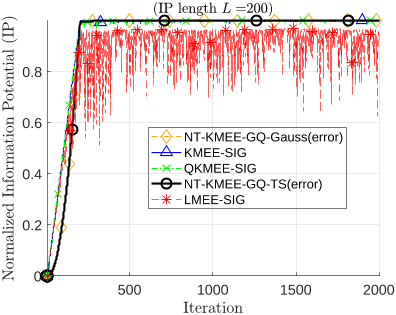

In [13]:
dataset[0]["image"]

In [15]:
from datasets import Dataset, DatasetDict

# Assuming your dataset is already loaded and stored in the variable `dataset`

# Splitting the dataset based on the 'folder' column
train_dataset = dataset.filter(lambda example: example['folder'] == 'train')
val_dataset = dataset.filter(lambda example: example['folder'] == 'val')
test_dataset = dataset.filter(lambda example: example['folder'] == 'test')

# Creating a DatasetDict with the split datasets
split_datasets = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': test_dataset})

# Printing out the number of rows in each split
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


  0%|          | 0/134 [00:00<?, ?ba/s]

  0%|          | 0/134 [00:00<?, ?ba/s]

  0%|          | 0/134 [00:00<?, ?ba/s]

Train dataset size: 106834
Val dataset size: 13354
Test dataset size: 13355


In [46]:
import random

# Determine the desired size of the reduced training dataset
desired_train_size = int(len(train_dataset) * 0.6)  # Reduce the size by 60%

# Randomly sample examples from the original training dataset to create the reduced training dataset
reduced_train_dataset = train_dataset.shuffle(seed=42).select(range(desired_train_size))

# Update the split_datasets dictionary with the reduced training dataset
split_datasets['train'] = reduced_train_dataset

# Printing out the number of rows in each split after reduction
print("Reduced Train dataset size:", len(reduced_train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


Reduced Train dataset size: 64100
Val dataset size: 13354
Test dataset size: 13355


Let's visualize a couple of samples from the training set.

## Preprocess the dataset

Since the dataset has two modalities (image and caption), the pre-processing pipeline will preprocess images and the captions.

To do so, load the processor class associated with the model you are about to fine-tune.

In [29]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [49]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


# train_dataset.set_transform(transforms
reduced_train_dataset.set_transform(transforms)

test_dataset.set_transform(transforms)

With the dataset ready, you can now set up the model for fine-tuning.

## Load a base model

Load the ["microsoft/git-base"](https://huggingface.co/microsoft/git-base) into a [`AutoModelForCausalLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) object.

In [50]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Evaluate

Image captioning models are typically evaluated with the [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge) or [Word Error Rate](https://huggingface.co/spaces/evaluate-metric/wer). For this guide, you will use the Word Error Rate (WER).

We use the 🤗 Evaluate library to do so. For potential limitations and other gotchas of the WER, refer to [this guide](https://huggingface.co/spaces/evaluate-metric/wer).

In [56]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train!

Now, you are ready to start fine-tuning the model. You will use the 🤗 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for this.

First, define the training arguments using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

In [65]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=4,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

Then pass them along with the datasets and the model to 🤗 Trainer.

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=reduced_train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

To start training, simply call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) on the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object.

In [67]:
torch.cuda.empty_cache()


In [68]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

You should see the training loss drop smoothly as training progresses.

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.save_model("modelv1")


In [ ]:
# trainer.push_to_hub()

## Inference

Take a sample image from `test_dataset` to test the model.

In [ ]:
# from PIL import Image
# import requests

# url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
# image = Image.open(requests.get(url, stream=True).raw)
# image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/test_image_image_cap.png" alt="Test image"/>
</div>
    
Prepare image for the model.

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# inputs = processor(images=image, return_tensors="pt").to(device)
# pixel_values = inputs.pixel_values

Call `generate` and decode the predictions.

In [ ]:
# generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
# generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# print(generated_caption)

```bash
a drawing of a pink and blue pokemon
```

Looks like the fine-tuned model generated a pretty good caption!